In [3]:
import os
from torch.utils.data import DataLoader, Subset
import torchvision
# from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
# ensure your output directory exists
os.makedirs("benchmarking", exist_ok=True)

In [4]:
import random
import torchvision.transforms.functional as F

class Compose(object):
    """Compose transforms that take (image, target) and return (image, target)."""
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    """Convert PIL image to Tensor (leave target untouched)."""
    def __call__(self, image, target):
        return F.to_tensor(image), target

class RandomHorizontalFlip(object):
    """Horizontally flip image & boxes with probability p."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, image, target):
        if random.random() < self.p:
            # flip image
            image = F.hflip(image)
            # flip boxes
            w, _ = image.size
            boxes = target["boxes"].clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return image, target

def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)

In [5]:
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair",
    "cow","diningtable","dog","horse","motorbike","person","pottedplant",
    "sheep","sofa","train","tvmonitor"
]

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        # build list of image IDs
        id_file = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")
        with open(id_file) as f:
            self.ids = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        # load image
        img_path = os.path.join(self.root, "JPEGImages", f"{img_id}.jpg")
        img = Image.open(img_path).convert("RGB")
        # parse annotation
        anno_path = os.path.join(self.root, "Annotations", f"{img_id}.xml")
        tree = ET.parse(anno_path)
        root = tree.getroot()
        boxes, labels = [], []
        for obj in root.findall("object"):
            cls = obj.find("name").text
            bbox = obj.find("bndbox")
            box = [int(bbox.find(x).text) for x in ("xmin","ymin","xmax","ymax")]
            boxes.append(box)
            labels.append(VOC_CLASSES.index(cls) + 1)  # +1 because 0 is reserved for background
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        # other required fields
        image_id = torch.tensor([idx])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

In [6]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)

# paths
voc_root = "/kaggle/input/voc2012/VOCdevkit/VOC2012"

# full datasets
dataset_train = VOCDataset(voc_root, "train", transforms=get_transform(True))
dataset_val   = VOCDataset(voc_root, "val",   transforms=get_transform(False))
raw_train = VOCDataset(voc_root, "train", transforms=None)

# (Optional) use a small subset for quick debugging
# indices = torch.randperm(len(dataset_train)).tolist()
# dataset_train = Subset(dataset_train, indices[:200])
# dataset_val   = Subset(dataset_val, indices[:50])

# DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset_train, batch_size=2, shuffle=True,
                          num_workers=4, collate_fn=collate_fn)
val_loader   = DataLoader(dataset_val,   batch_size=1, shuffle=False,
                          num_workers=2, collate_fn=collate_fn)

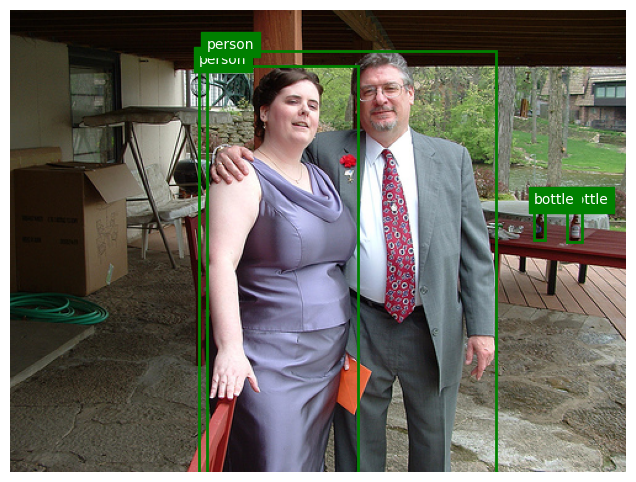

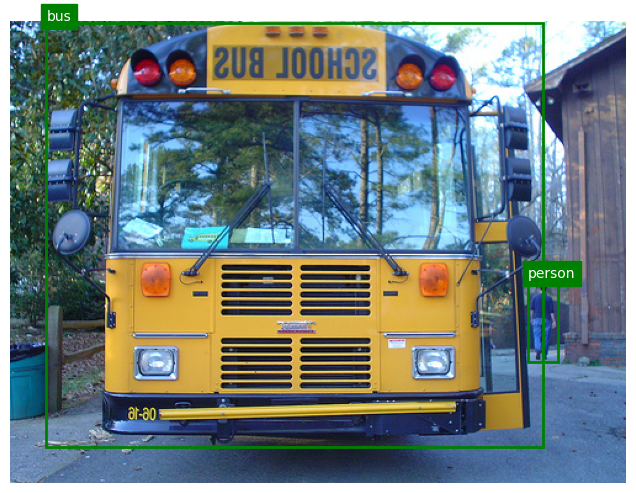

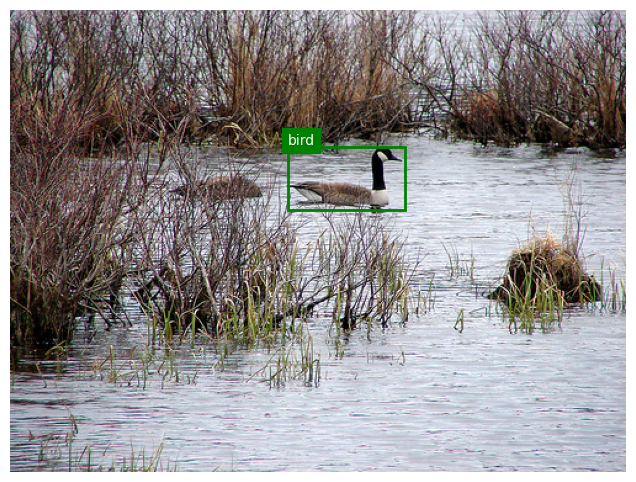

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_samples(dataset, num_samples=3):
    for idx in random.sample(range(len(dataset)), num_samples):
        img, target = dataset[idx]
        # handle both Tensor and PIL
        if torch.is_tensor(img):
            img_np = img.mul(255).permute(1,2,0).byte().cpu().numpy()
        else:
            img_np = np.array(img)
        boxes  = target["boxes"].cpu().numpy()
        labels = target["labels"].cpu().numpy()

        plt.figure(figsize=(8,6))
        plt.imshow(img_np)
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            ax.add_patch(plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                                       fill=False, edgecolor="g", linewidth=2))
            ax.text(xmin, ymin-2, VOC_CLASSES[label-1],
                    fontsize=10, color="white", backgroundcolor="g")
        plt.axis("off")
        plt.show()

# visualize transformed samples
visualize_samples(dataset_train, num_samples=3)

# (or raw, untransformed samples)
# visualize_samples(raw_train, num_samples=3)

In [8]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

# 2. Load pretrained Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 3. Replace the classifier head for Pascal VOC (20 classes + background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(VOC_CLASSES) + 1  # +1 for background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 4. Move to GPU (if available)
model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 176MB/s]  


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# Only parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]

# Stochastic Gradient Descent with momentum and weight decay
optimizer = torch.optim.SGD(
    params,
    lr=0.005,            # you can tune this
    momentum=0.9,
    weight_decay=0.0005
)

# Decay LR by 0.1 every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100):
    model.train()
    running_loss = 0.0

    for i, (images, targets) in enumerate(data_loader):
        # move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward + compute losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        # backward + optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # log
        if (i + 1) % print_freq == 0:
            avg = running_loss / print_freq
            print(f"Epoch {epoch} | Iter {i+1}/{len(data_loader)} | Avg Loss: {avg:.4f}")
            running_loss = 0.0

# Full training run
num_epochs = 5
# path to whichever checkpoint you want to resume from:
ckpt_path = "benchmarking/checkpoint_epoch2.pth"

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optim_state"])
    lr_scheduler.load_state_dict(ckpt["sched_state"])
    start_epoch = ckpt["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("No checkpoint found, starting from scratch")

for epoch in range(start_epoch, num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    # save full checkpoint
    torch.save({
        "epoch":          epoch,
        "model_state":    model.state_dict(),
        "optim_state":    optimizer.state_dict(),
        "sched_state":    lr_scheduler.state_dict()
    }, f"benchmarking/checkpoint_epoch{epoch}.pth")
    print(f"Saved full checkpoint: benchmarking/checkpoint_epoch{epoch}.pth")

No checkpoint found, starting from scratch
Epoch 0 | Iter 100/2859 | Avg Loss: 0.6884
Epoch 0 | Iter 200/2859 | Avg Loss: 0.5783
Epoch 0 | Iter 300/2859 | Avg Loss: 0.5211
Epoch 0 | Iter 400/2859 | Avg Loss: 0.4527
Epoch 0 | Iter 500/2859 | Avg Loss: 0.4663
Epoch 0 | Iter 600/2859 | Avg Loss: 0.4226
Epoch 0 | Iter 700/2859 | Avg Loss: 0.4091
Epoch 0 | Iter 800/2859 | Avg Loss: 0.3954
Epoch 0 | Iter 900/2859 | Avg Loss: 0.3524
Epoch 0 | Iter 1000/2859 | Avg Loss: 0.4255
Epoch 0 | Iter 1100/2859 | Avg Loss: 0.4132
Epoch 0 | Iter 1200/2859 | Avg Loss: 0.3467
Epoch 0 | Iter 1300/2859 | Avg Loss: 0.3695
Epoch 0 | Iter 1400/2859 | Avg Loss: 0.3570
Epoch 0 | Iter 1500/2859 | Avg Loss: 0.3590
Epoch 0 | Iter 1600/2859 | Avg Loss: 0.3881
Epoch 0 | Iter 1700/2859 | Avg Loss: 0.3839
Epoch 0 | Iter 1800/2859 | Avg Loss: 0.3811
Epoch 0 | Iter 1900/2859 | Avg Loss: 0.3353
Epoch 0 | Iter 2000/2859 | Avg Loss: 0.3692
Epoch 0 | Iter 2100/2859 | Avg Loss: 0.3665
Epoch 0 | Iter 2200/2859 | Avg Loss: 0.320

In [ ]:
%%bash
cat > voc2coco.py << 'EOF'
import os
import json
import xml.etree.ElementTree as ET
import argparse

def parse_args():
    parser = argparse.ArgumentParser(
        description='Convert Pascal VOC annotations to COCO format JSON')
    parser.add_argument('--voc_dir', type=str, required=True,
                        help='Path to VOCdevkit/VOC2012 directory')
    parser.add_argument('--image_set', type=str, default='val',
                        help='Image set to convert (e.g., train, val, trainval)')
    parser.add_argument('--output', type=str, required=True,
                        help='Path to output COCO JSON (e.g., instances_val.json)')
    return parser.parse_args()

VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair",
    "cow","diningtable","dog","horse","motorbike","person","pottedplant",
    "sheep","sofa","train","tvmonitor"
]


def voc_to_coco(voc_dir, image_set, output_path):
    # Paths
    img_dir = os.path.join(voc_dir, 'JPEGImages')
    ann_dir = os.path.join(voc_dir, 'Annotations')
    set_file = os.path.join(voc_dir, 'ImageSets', 'Main', f'{image_set}.txt')

    # Read image ids
    with open(set_file) as f:
        image_ids = [x.strip() for x in f.readlines()]

    images = []
    annotations = []
    ann_id = 1

    for img_id in image_ids:
        # Parse image size
        xml_path = os.path.join(ann_dir, f'{img_id}.xml')
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Add image entry
        images.append({
            'id': int(img_id),
            'file_name': f'{img_id}.jpg',
            'width': width,
            'height': height
        })

        # Parse objects
        for obj in root.findall('object'):
            cls = obj.find('name').text
            if cls not in VOC_CLASSES:
                continue
            category_id = VOC_CLASSES.index(cls) + 1  # 1-based
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text) - 1
            ymin = int(bbox.find('ymin').text) - 1
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            o_width = xmax - xmin
            o_height = ymax - ymin
            area = o_width * o_height

            annotations.append({
                'id': ann_id,
                'image_id': int(img_id),
                'category_id': category_id,
                'bbox': [xmin, ymin, o_width, o_height],
                'area': area,
                'iscrowd': 0
            })
            ann_id += 1

    # Prepare categories
    categories = []
    for idx, cls in enumerate(VOC_CLASSES, start=1):
        categories.append({
            'id': idx,
            'name': cls,
            'supercategory': 'none'
        })

    # Build final JSON
    coco = {
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

    # Write to file
    with open(output_path, 'w') as f:
        json.dump(coco, f)
    print(f"COCO JSON saved to {output_path}")


if __name__ == '__main__':
    args = parse_args()
    voc_to_coco(args.voc_dir, args.image_set, args.output)
EOF

In [ ]:
!python voc2coco.py \
  --voc_dir "/kaggle/input/voc2012/VOCdevkit/VOC2012" \
  --image_set val \
  --output "benchmarking/instances_val.json"

In [10]:
ckpt = torch.load("benchmarking/checkpoint_epoch4.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
# optimizer.load_state_dict(ckpt["optim_state"])  # if you need to resume training
# lr_scheduler.load_state_dict(ckpt["sched_state"])
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
# 9.1 Imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# 9.2 Load ground truth
coco_gt = COCO("/kaggle/working/benchmarking/instances_val.json")

# ── Inject the missing fields **immediately**:
coco_gt.dataset['info']     = {}
coco_gt.dataset['licenses'] = []

# 9.3 Run model on entire val set, collect detections
detections = []
model.eval()

# dataset_val.ids is the list of VOC filenames (without .jpg), e.g. "2008_000003"
for idx, img_id_str in enumerate(dataset_val.ids):
    img, _ = dataset_val[idx]
    # COCO GT used `int(img_id_str)` as the image_id
    img_id = int(img_id_str)  

    with torch.no_grad():
        out = model([img.to(device)])[0]

    boxes  = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()
    labels = out["labels"].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        detections.append({
            "image_id":    img_id,
            "category_id": int(label),
            "bbox":        [x1, y1, x2 - x1, y2 - y1],
            "score":       float(score)
        })
# 9.4 Write results file
with open("benchmarking/fasterrcnn_results.json", "w") as f:
    json.dump(detections, f)

# 9.5 Load results & run COCOeval
coco_dt   = coco_gt.loadRes("benchmarking/fasterrcnn_results.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = coco_gt.getImgIds()
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.68s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.07s).
Accumulating evaluation results...
DONE (t=1.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [12]:
import time

model.eval()
total_images = 0
start = time.time()

for images, _ in val_loader:
    images = [img.to(device) for img in images]
    with torch.no_grad():
        _ = model(images)
    total_images += len(images)

torch.cuda.synchronize()
elapsed = time.time() - start
fps = total_images / elapsed
print(f"▶ Inference speed: {fps:.1f} FPS")

# Save alongside your mAP stats
metrics = {
    "AP@[.5:.95]":  coco_eval.stats[0].item(),
    "AP@.5":       coco_eval.stats[1].item(),
    "AP@.75":      coco_eval.stats[2].item(),
    "FPS":         fps
}
with open("benchmarking/metrics_fasterrcnn.json","w") as f:
    json.dump(metrics, f, indent=2)

▶ Inference speed: 8.2 FPS


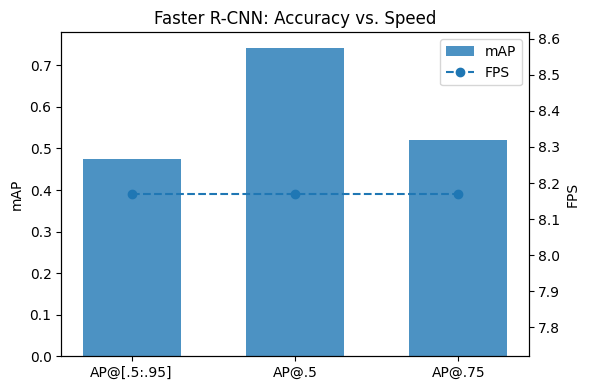

In [13]:
import matplotlib.pyplot as plt
import json

# Load your saved metrics
with open("benchmarking/metrics_fasterrcnn.json") as f:
    m = json.load(f)

# Bar chart for mAP, line for FPS
fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

# mAP bars
keys = ["AP@[.5:.95]", "AP@.5", "AP@.75"]
vals = [m[k] for k in keys]
ax1.bar(range(len(keys)), vals, width=0.6, label="mAP", alpha=0.8)
ax1.set_xticks(range(len(keys)))
ax1.set_xticklabels(keys)
ax1.set_ylabel("mAP")

# FPS line
ax2.plot(range(len(keys)), [m["FPS"]]*3, marker="o", linestyle="--", label="FPS")
ax2.set_ylabel("FPS")

# Legend & title
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")
plt.title("Faster R-CNN: Accuracy vs. Speed")
plt.tight_layout()
plt.savefig("benchmarking/accuracy_vs_speed_fasterrcnn.png", dpi=150)
plt.show()

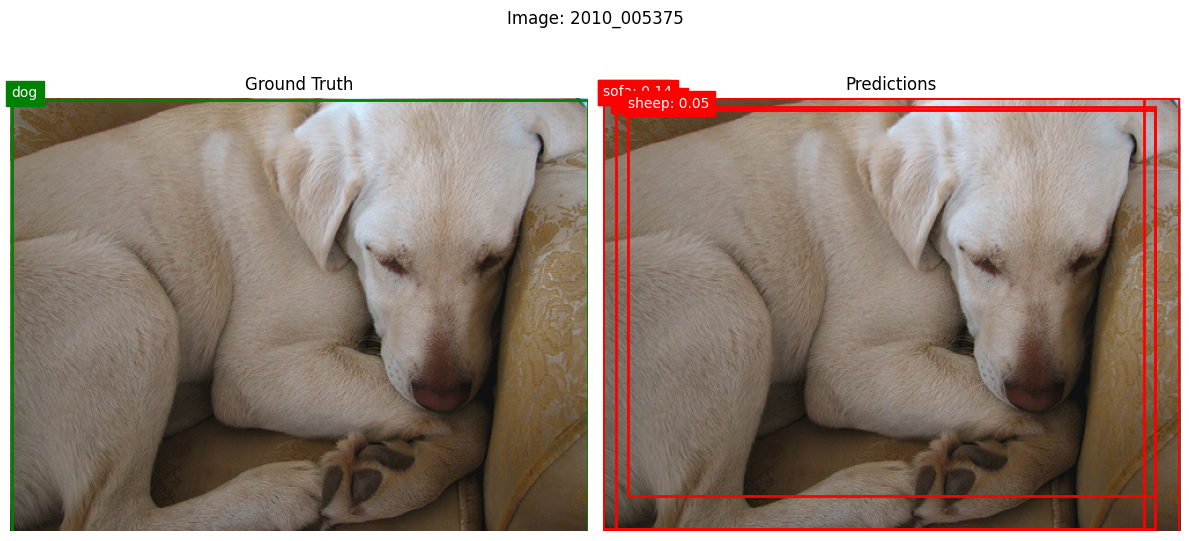

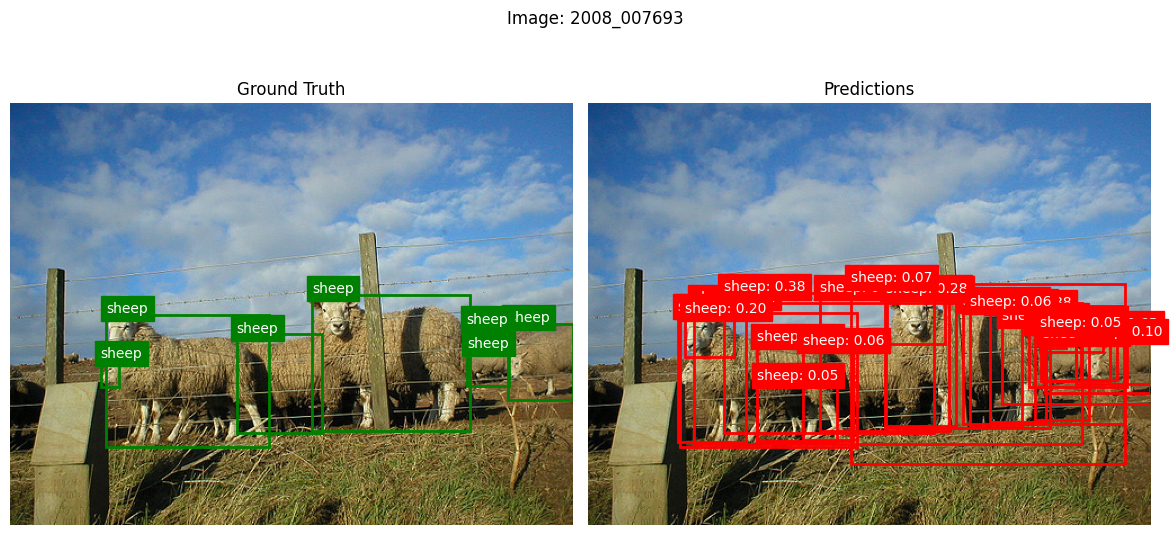

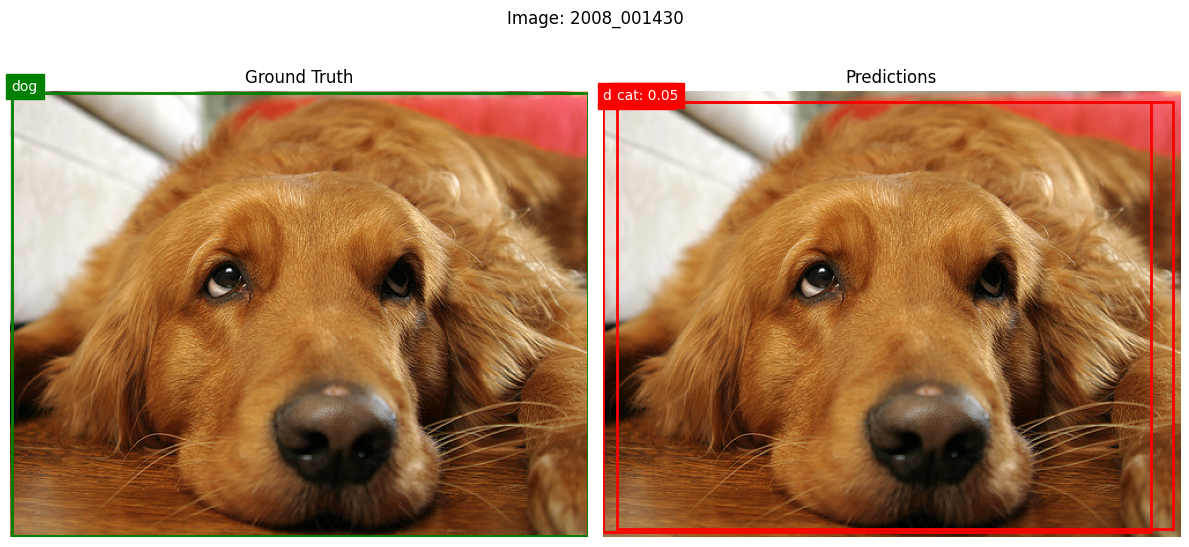

In [15]:
import random
import matplotlib.pyplot as plt

sample_ids = random.sample(dataset_val.ids, 3)

for img_id_str in sample_ids:
    idx = dataset_val.ids.index(img_id_str)
    img, gt = dataset_val[idx]
    with torch.no_grad():
        pred = model([img.to(device)])[0]

    # Convert tensor → numpy for plotting
    img_np = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()
    gt_boxes  = gt["boxes"].cpu().numpy()
    gt_labels = gt["labels"].cpu().numpy()
    pr_boxes  = pred["boxes"].cpu().numpy()
    pr_labels = pred["labels"].cpu().numpy()
    pr_scores = pred["scores"].cpu().numpy()

    # Create side-by-side plots
    fig, (ax_gt, ax_pr) = plt.subplots(1, 2, figsize=(12, 6))

    # --- Ground Truth ---
    ax_gt.imshow(img_np)
    for box, label in zip(gt_boxes, gt_labels):
        x1, y1, x2, y2 = box
        ax_gt.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, edgecolor="g", linewidth=2))
        ax_gt.text(x1, y1 - 2, VOC_CLASSES[label - 1],
                   color="white", backgroundcolor="g", fontsize=10)
    ax_gt.set_title("Ground Truth")
    ax_gt.axis("off")

    # --- Predictions ---
    ax_pr.imshow(img_np)
    for box, label, score in zip(pr_boxes, pr_labels, pr_scores):
        x1, y1, x2, y2 = box
        ax_pr.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, edgecolor="r", linewidth=2))
        ax_pr.text(x1, y1 - 2, f"{VOC_CLASSES[label - 1]}: {score:.2f}",
                   color="white", backgroundcolor="r", fontsize=10)
    ax_pr.set_title("Predictions")
    ax_pr.axis("off")

    plt.suptitle(f"Image: {img_id_str}")
    plt.tight_layout()
    plt.show()


In [16]:
%%bash
cd /kaggle/working
zip -r working_bundle.zip .

  adding: state.db (deflated 60%)
  adding: .virtual_documents/ (stored 0%)
  adding: benchmarking/ (stored 0%)
  adding: benchmarking/checkpoint_epoch1.pth (deflated 7%)
  adding: benchmarking/checkpoint_epoch3.pth (deflated 7%)
  adding: benchmarking/checkpoint_epoch2.pth (deflated 7%)
  adding: benchmarking/metrics_fasterrcnn.json (deflated 28%)
  adding: benchmarking/checkpoint_epoch0.pth (deflated 7%)
  adding: benchmarking/fasterrcnn_results.json (deflated 71%)
  adding: benchmarking/checkpoint_epoch4.pth (deflated 7%)
  adding: benchmarking/accuracy_vs_speed_fasterrcnn.png (deflated 18%)
  adding: benchmarking/instances_val.json (deflated 85%)
  adding: voc2coco.py (deflated 62%)
